# Imports

In [25]:
'''
Defining all imports as per instructions
libraries required:
- dumps 
- get 
- pandas 
- numpy
- matplotlib

'''
from json import dumps
from requests import get
from http import HTTPStatus
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Activity 1

## 1.1 Sub-activity: Open Data COVID-19 API

### Task 1

In [26]:
def  get_API_data(filters, structure):

    #variable endpoint corresponds to the API to which this script is connecting to 
    #in order to obtain the data
    endpoint = "https://api.coronavirus.data.gov.uk/v1/data"
    
    #API expects data retrieval in the form of a string
    #but the function structure and instruction expects a dictionary
    #JSON dumps function solves this matter
    api_params = {
        "filters": str.join(";", filters),
        "structure": dumps(structure, separators=(",", ":")),
        "format": "json"
    }

    data = list()

    page_number = 1
    
    #referencing script below: 
    #Coronavirus.data.gov.uk. 2022. [online] Available at: <https://coronavirus.data.gov.uk/details/developers-guide/main-api#params-page> [Accessed 18 January 2022].
    #the script is effectively the SDK server connector loop for accessing the API and executing queries on the data
    while True:
        api_params["page"] = page_number

        response = get(endpoint, params=api_params, timeout=10)

        if response.status_code >= HTTPStatus.BAD_REQUEST:
            raise RuntimeError(f'Request failed: {response.text}')
        elif response.status_code == HTTPStatus.NO_CONTENT:
            break
    #saving data as dictionary
        current_data = response.json()
        page_data = current_data['data']
    #the command extend is similar to append but for bigger lists, it iterates over its argument adding each element
        data.extend(page_data)
    #if the data reaches the conclusion, stop requesting the data by breaking loop
        if current_data["pagination"]["next"] is None:
            break
    #counter to move to the next "pagination" of the data
        page_number += 1

    return data

### Task 2

In [27]:
'''
Please note that depending on internet connection and how fast the API response time is, unit testings for possible 
print statements of the data might vary in time, so a little waiting time of a few seconds is expected.

'''
#defining query structure with appropriate names of key-value pairs 
query_structure = {
    "date": "date",
    "name": "areaName",
    "daily_cases" : "newCasesBySpecimenDate",
    "cumulative_cases" : "cumCasesBySpecimenDate",
    "daily_deaths" : "newDeaths28DaysByPublishDate",
    "cumulative_deaths": "cumDeaths28DaysByPublishDate",
    "cumulative_vaccinated" : "cumPeopleVaccinatedCompleteByVaccinationDate",
    "vaccination_age" : "vaccinationsAgeDemographics"
}

#producing two lists of dictionaries
results_json_national = get_API_data(filters = [f"areaType=nation"], structure = query_structure)
results_json_regional = get_API_data(filters = [f"areaType=region"], structure = query_structure)


#testing some statements to see if the API can retrieve query structures properly. 

#print("Length of national Data:", len(results_json_national))
#print("Length of regional Data:", len(results_json_regional))
#print("Regional Data :", results_json_regional[0])
#print()
#print("National Data :", results_json_national[0])

## 1.2 Sub-activity: Shaping the COVID data into different dataframes

### Task 3

In [28]:
temp = results_json_national
temp.extend(results_json_regional)
covid_data_list = temp
#extend adds all the values of the child list into parent list. Eg, a.extend(b) will add all values of b in a.
#creating a temp value to execute concatenation into a single list

### Task 4

In [29]:
covid_data = pd.DataFrame(covid_data_list)
#converting list into a datafram with name covid_data
#tested, it does contain one column for each metric
#covid_data.head()

### Task 5

In [30]:
covid_data = covid_data[covid_data['name'] != 'England']
#df[df['a'] == 'x']] this will get all the rows which has 'x' as value in 'a' column

### Task 6

In [31]:
covid_data.rename(columns = {'name':'area'}, inplace = True)
#changing name into 'area'

### Task 7

In [32]:
covid_data['date']= pd.to_datetime(covid_data['date'])
#converting entire column 'date' into datetime using pd.to_datetime

### Task 8

In [33]:
print("Summary of dataframe with count of null values:\n")
print("Column                 null-count")
print(covid_data.isnull().sum())


#empty lists in the column vaccination_age are NOT considered null. 
#while NaN for object/string and float value is considered as null

#the .isnull() function does not consider [] as null values. And if we wanted to consider those as null, 
#then we would have required to iterate the values in that column to check for how many times the [] occur. 
#but for simplicity, we have considered [] as not null

Summary of dataframe with count of null values:

Column                 null-count
date                        0
area                        0
daily_cases                14
cumulative_cases           13
daily_deaths             1699
cumulative_deaths        1665
cumulative_vaccinated    4325
vaccination_age             0
dtype: int64


### Task 9

In [34]:
#sort covid_data date wise and store in a temporary datafram
#settingWithCopyWarning Solution: https://stackoverflow.com/questions/20625582/how-to-deal-with-settingwithcopywarning-in-pandas
pd.options.mode.chained_assignment = None

temp = covid_data.copy()
temp = temp.sort_values(by = 'date', ascending = False)


#for each of three cases below, the for loop checks for null values
#then a while loop runs to check the first/latest value which is not null. 
#while loop will start running when it reaches not null values
#the second while loop in each block makes sure that the other consecutive NaN values are also dealt with
#by replacing them with the most not-null value

#filling NaN for cumulative_cases
for i in range(len(temp['cumulative_cases'])):
    if temp['cumulative_cases'].isnull().iloc[i] :
        j = i
        while(j<len(temp['cumulative_cases'])- 1 and temp['cumulative_cases'].isnull().iloc[j]):
            j += 1
        k = j-1
        while(k >= i):
            covid_data.loc[temp.index[k], 'cumulative_cases'] = temp['cumulative_cases'].iloc[j]
            temp['cumulative_cases'].iloc[k] = 0
            k -= 1
        
#filling NaN for cumulative_deaths
for i in range(len(temp['cumulative_deaths'])):
    if temp['cumulative_deaths'].isnull().iloc[i] :
        j = i
        while(j<len(temp['cumulative_deaths'])- 1 and temp['cumulative_deaths'].isnull().iloc[j]):
            j += 1
        k = j-1
        while(k >= i):
            covid_data.loc[temp.index[k], 'cumulative_deaths'] = temp['cumulative_deaths'].iloc[j]
            temp['cumulative_deaths'].iloc[k] = 0
            k -= 1
        
#filling NaN for cumulative_vaccinated
for i in range(len(temp['cumulative_vaccinated'])):
    if temp['cumulative_vaccinated'].isnull().iloc[i] :
        j = i
        while(j<len(temp['cumulative_vaccinated'])- 1 and temp['cumulative_vaccinated'].isnull().iloc[j]):
            j += 1
        k = j-1
        while(k >= i):
            covid_data.loc[temp.index[k], 'cumulative_vaccinated'] = temp['cumulative_vaccinated'].iloc[j]
            temp['cumulative_vaccinated'].iloc[k] = 0
            k -= 1
            
#.iloc[i] gives an entire row at ith index
#.loc[i, 'A'] gives a single value at ith row and Ath column

### Task 10

In [35]:
covid_data.dropna(subset=['cumulative_deaths', 'cumulative_cases', 'cumulative_vaccinated'], inplace=True)
#remove rows which still have missing values in the cummulative metrics

### Task 11

In [36]:
#rolling averages task 
#creating two new columns
#one for rolling average for cases and one for deaths
roll_avg_cases = []
roll_avg_deaths = []

#function.rolling() takes as parameters window and min_periods to calculate the mean, this is being calculated over 7-days
#data being iterated to calculate rolling average using for loop below
#creating 2 temp variables to calculare roll avg for daily cases and for deaths
for city in set(covid_data['area']):
    temp_list1 = covid_data[covid_data['area'] == city]['daily_cases'].rolling(window=7, min_periods = 1).mean().values
    roll_avg_cases.extend(temp_list1)
    
    temp_list2 = covid_data[covid_data['area'] == city]['daily_deaths'].rolling(window=7, min_periods = 1).mean().values
    roll_avg_deaths.extend(temp_list2)

#renaming as per instructions
covid_data['daily_cases_roll_avg'] = roll_avg_cases
covid_data['daily_deaths_roll_avg'] = roll_avg_deaths

### Task 12

In [37]:
covid_data = covid_data.drop(['daily_cases', 'daily_deaths'], 1)
#dropping/removing the columns daily deaths and daily cases

### Task 13

In [38]:
covid_data_vaccinations = covid_data[['date', 'area', 'vaccination_age']].copy()
covid_data = covid_data.drop('vaccination_age', 1)
#copying necessary columns into a new data fram called covid_data_vaccinations in first line 
#dropping the vaccination_age column in second line

### Task 14

In [39]:
'''
please note: the running time for this code takes for some reason 30 seconds to 1 minute on my machine. 
May take sometime before running completely

'''
#drop all rows with vaccination_age = []
vaccine_data = covid_data_vaccinations['vaccination_age'].values
cv_indexes = covid_data_vaccinations.index

#for loop checks if the length of the value at column is 0, if true, drop entire row
for i in range(len(vaccine_data)):
    if len(vaccine_data[i]) == 0:
        covid_data_vaccinations = covid_data_vaccinations.drop(cv_indexes[i], 0)

#creating wide dataframe
covid_data_vaccinations_wide = pd.DataFrame(covid_data_vaccinations['vaccination_age'].iloc[0])
covid_data_vaccinations_wide['date'] = [covid_data_vaccinations['date'].iloc[0]]*len(covid_data_vaccinations['vaccination_age'].iloc[0])
covid_data_vaccinations_wide['area'] = [covid_data_vaccinations['area'].iloc[0]]*len(covid_data_vaccinations['vaccination_age'].iloc[0])

#extracting from the column vaccination age and making a new data fram with those columns
for i in range(1, len(covid_data_vaccinations)):
    df = pd.DataFrame(covid_data_vaccinations['vaccination_age'].iloc[i])
    df['date'] = [covid_data_vaccinations['date'].iloc[i]]*len(covid_data_vaccinations['vaccination_age'].iloc[i])
    df['area'] = [covid_data_vaccinations['area'].iloc[i]]*len(covid_data_vaccinations['vaccination_age'].iloc[i])
    
    covid_data_vaccinations_wide = pd.concat([covid_data_vaccinations_wide, df], axis = 0)
    
covid_data_vaccinations_wide.index = np.arange(0, len(covid_data_vaccinations_wide))

#dropping prev columns
covid_data_vaccinations_wide = covid_data_vaccinations_wide.drop(['cumPeopleVaccinatedThirdInjectionByVaccinationDate', 'newPeopleVaccinatedThirdInjectionByVaccinationDate', 'cumVaccinationThirdInjectionUptakeByVaccinationDatePercentage'], 1)

## 1.3 Sub-activity: Aggregating, plotting, and analysing

### Task 15

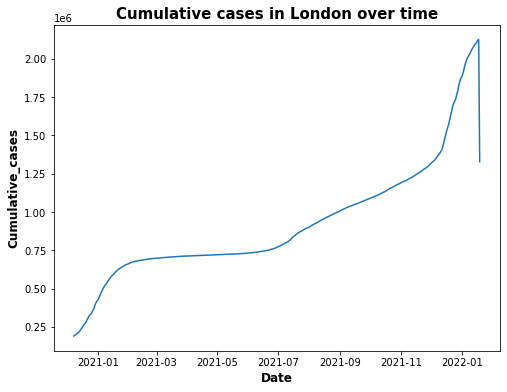

In [42]:
# 1. Aggregrate the data as an intermediate dataframe
#slice dataframe to get data for only date and cumulative_cases columns where area = 'London'
intermediate_df = covid_data[covid_data['area'] == 'London'][['date', 'cumulative_cases']]
    
# 2. Plot to visualize the transform data
plt.subplots(figsize =(8, 6))
plt.plot('date', 'cumulative_cases', data = intermediate_df)
plt.xlabel('Date', fontweight ='bold', fontsize = 12)
plt.ylabel('Cumulative_cases', fontweight ='bold', fontsize = 12)
plt.title('Cumulative cases in London over time', fontweight ='bold', fontsize = 15)
plt.show()

# 3. Answer the question posed with comment
# Cases plateaued between Feb 2021 to July 2021 as it seems the curve has stabilized during this period (flat line)

### Task 16

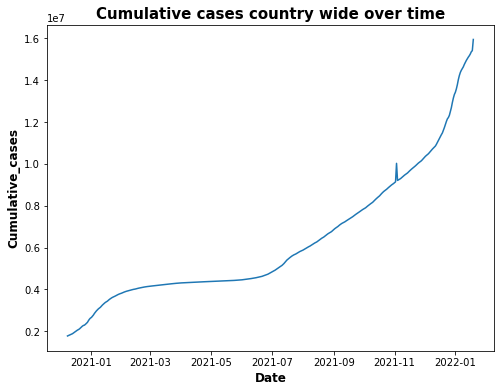

In [44]:
# 1. Aggregrate the data as an intermediate dataframe
# slice dataframe to get data for only date and cumulative_cases columns, summed over all areas for every available date
intermediate_df = covid_data.groupby('date').sum()

# 2. Plot to visualize the transform data
plt.subplots(figsize =(8, 6))
plt.plot(intermediate_df.index, intermediate_df['cumulative_cases'])
plt.xlabel('Date', fontweight ='bold', fontsize = 12)
plt.ylabel('Cumulative_cases', fontweight ='bold', fontsize = 12)
plt.title('Cumulative cases country wide over time', fontweight ='bold', fontsize = 15)
plt.show()

# 3. Answer the question posed with comment
# the pattern in London is similar to pattern country wide, there is a similar plateau to previous visualisation.
# similar to the previous graph it also shows an increase of cummulative cases after 2021-07

### Task 17

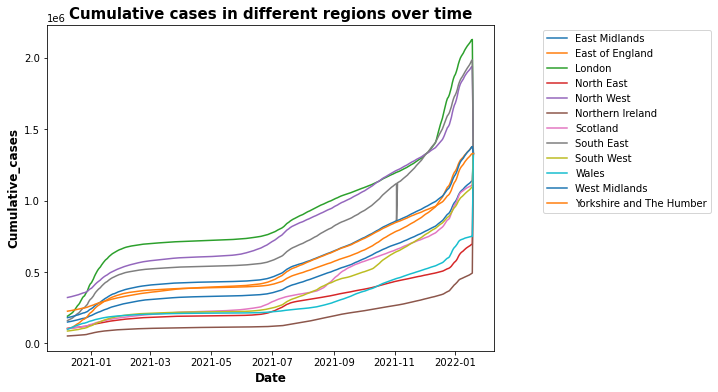

In [46]:
# 1. Aggregrate the data as an intermediate dataframe
# No such transformation required. The figure can be plotted directly with below code

    
# 2. Plot to visualize the transform data
plt.subplots(figsize =(8, 6))
for key, grp in covid_data.groupby('area'):
    plt.plot(grp['date'], grp['cumulative_cases'], label = key)

plt.legend(bbox_to_anchor=(1.1, 1.0))

plt.xlabel('Date', fontweight ='bold', fontsize = 12)
plt.ylabel('Cumulative_cases', fontweight ='bold', fontsize = 12)
plt.title('Cumulative cases in different regions over time', fontweight ='bold', fontsize = 15)
plt.show()

plt.show()

# 3. Answer the question posed with comment
# In all regions, cases first rose till Feb 2021 and then plateaued till July 2021 and then increased again
# they all show a very similar trend/pattern, some areas had a bigger increase e.g. London, but this could 
# be due to the population per density area in the city (which is very high compared to other regions)

### Task 18


Question: As a data scientist you will often need to interpret data insights, based on your
own judgement and expertise. Considering the data and plot from the last question, what
event could have taken place in June-July that could justify the trend seen from there
onward?

Answer: Large gatherings of crowd or not maintaining proper social distance could have increased the number of cases from month. Or another covid mutant (Delta Variant) might have spread during that time.

### Task 19

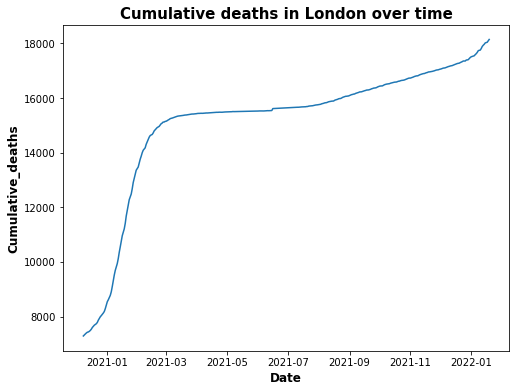

In [47]:
# 1. Aggregrate the data as an intermediate dataframe
# slice dataframe to get data for only date and cumulative_deaths columns, where area = 'London'
intermediate_df = covid_data[covid_data['area'] == 'London'][['date', 'cumulative_deaths']]

# 2. Plot to visualize the transform data
plt.subplots(figsize =(8, 6))
plt.plot('date', 'cumulative_deaths', data = intermediate_df)
plt.xlabel('Date', fontweight ='bold', fontsize = 12)
plt.ylabel('Cumulative_deaths', fontweight ='bold', fontsize = 12)
plt.title('Cumulative deaths in London over time', fontweight ='bold', fontsize = 15)
plt.show()
# 3. Answer the question posed with comment
# After Feb-Mar 2021, the number of deaths seemed to be plateaued, and the ongoing tred of increase 
# in number of deaths seems to have stabilized

### Task 20

Question: Based on the data and plot from the last question, is there any similarity between trends in cumulative cases and cumulative deaths?

Answer: Both cumulative cases and cumulative deaths plateaued after Feb 2021 till July 2021 where a point of stability has been seemingly reached. 


### Task 21

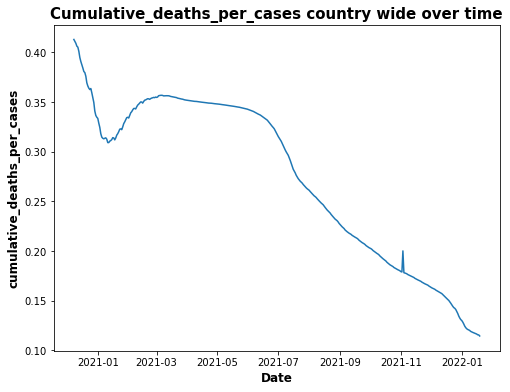

In [48]:
# 1. Aggregrate the data as an intermediate dataframe
# creating a column cumulative_deaths_per_cases by dividing cumulative_deaths with cumulative_cases

# the below line is to ignore the SettingWithCopyWarning given pandas
intermediate_df = covid_data[['date', 'cumulative_cases', 'cumulative_deaths']]
intermediate_df['cumulative_deaths_per_cases'] = intermediate_df['cumulative_deaths'].values/intermediate_df['cumulative_cases'].values
intermediate_df = intermediate_df.groupby('date').sum()

# 2. Plot to visualize the transform data
# .plot(y = '')
plt.subplots(figsize =(8, 6))
plt.plot(intermediate_df.index, intermediate_df['cumulative_deaths_per_cases'])
plt.xlabel('Date', fontweight ='bold', fontsize = 12)
plt.ylabel('cumulative_deaths_per_cases', fontweight ='bold', fontsize = 12)
plt.title('Cumulative_deaths_per_cases country wide over time', fontweight ='bold', fontsize = 15)
plt.show()

# 3. Answer the question posed with comment
# the number of deaths per cases is generally decreasing throughout the time, but showed a plateaue from Feb 2021 to July 2021

### Task 22

Question: Based on the data and plot from the last question, it seems like, in June-July,
the graph’s inclination gets steeper. What could be a reasonable explanation?

Answer: The reason for steeper inclination can be high number of cases but lower deaths. This can be the result of vaccination, or stronger immunity towards the disease, possibly successful restrictions outcome could be a reason as well. 

### Task 23

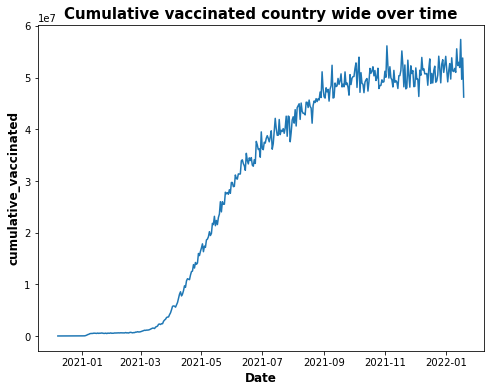

In [52]:
# 1. Aggregrate the data as an intermediate dataframe
# dataframe summed over all areas for every available date
intermediate_df = covid_data.groupby('date').sum()

# 2. Plot to visualize the transform data
plt.subplots(figsize =(8, 6))
plt.plot(intermediate_df.index, intermediate_df['cumulative_vaccinated'])
plt.xlabel('Date', fontweight ='bold', fontsize = 12)
plt.ylabel('cumulative_vaccinated', fontweight ='bold', fontsize = 12)
plt.title('Cumulative vaccinated country wide over time', fontweight ='bold', fontsize = 15)
plt.show()

# 3. Answer the question posed with comment
# The number of vaccinated people are high after July, which shows lower deaths even with the rise in number of cases
# there is some noise on the graph because of possible errors/erroneous processes during data collection.

### Task 24

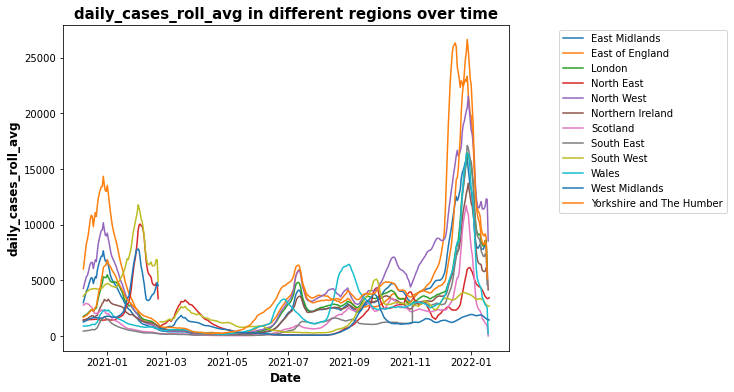

In [54]:
# 1. Aggregrate the data as an intermediate dataframe
# No such transformation required. The figure can be plotted directly with below code

# 2. Plot to visualize the transform data
plt.subplots(figsize =(8, 6))
for key, grp in covid_data.groupby('area'):
    plt.plot(grp['date'], grp['daily_cases_roll_avg'], label = key)

plt.legend(bbox_to_anchor=(1.1, 1.0))
plt.xlabel('Date', fontweight ='bold', fontsize = 12)
plt.ylabel('daily_cases_roll_avg', fontweight ='bold', fontsize = 12)
plt.title('daily_cases_roll_avg in different regions over time', fontweight ='bold', fontsize = 15)
plt.show()

# 3. Answer the question posed with comment
# from the graph, it seems that East of England differ from the general trend showing high values 
# of daily cases accross the time series, possibly for not respecting restrictions. This pattern emerges on the eye
# quite easily as it shows some high value clusters both at the beginning and end of the time series

### Task 25

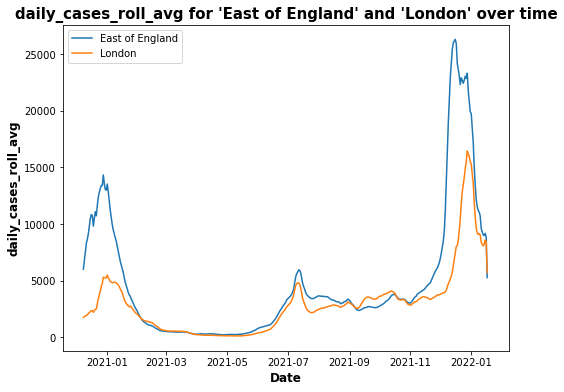

In [58]:
# 1. Aggregrate the data as an intermediate dataframe
# slicing the dataframe to extract data where area = required location
df1 = covid_data[covid_data['area'] == 'East of England']
df2 = covid_data[covid_data['area'] == 'London']

# 2. Plot to visualize the transform data
plt.subplots(figsize =(8, 6))

plt.plot(df1['date'], df1['daily_cases_roll_avg'], label = 'East of England')
plt.plot(df2['date'], df2['daily_cases_roll_avg'], label = 'London')

plt.legend()
plt.xlabel('Date', fontweight ='bold', fontsize = 12)
plt.ylabel('daily_cases_roll_avg', fontweight ='bold', fontsize = 12)
plt.title("daily_cases_roll_avg for 'East of England' and 'London' over time", fontweight ='bold', fontsize = 15)
plt.show()


# 3. Answer the question posed with comment
# In East of England, from the graph trend, there is a notable difference. Reasons to justify the difference might include 
# the social distances guidelines/covid guidelines do not seem to have worked in the East of England.
# We know this from the London comparison and over the period of one year many more cases compared to a 
# city in the normal trend (following the general pattern)

### Task 26

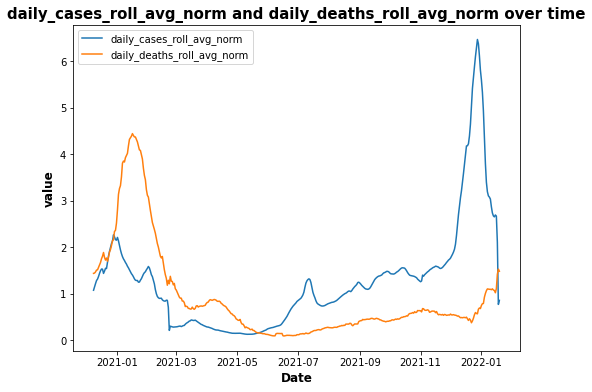

In [59]:
# 1. Aggregrate the data as an intermediate dataframe
# normalizing the columns daily_cases_roll_avg and daily_deaths_roll_avg by dividing with their respective maximum value
intermediate_df = covid_data[['area', 'date', 'daily_cases_roll_avg', 'daily_deaths_roll_avg']]
intermediate_df['daily_cases_roll_avg_norm'] = intermediate_df['daily_cases_roll_avg'].values/intermediate_df['daily_cases_roll_avg'].max()
intermediate_df['daily_deaths_roll_avg_norm'] = intermediate_df['daily_deaths_roll_avg'].values/intermediate_df['daily_deaths_roll_avg'].max()

intermediate_df = intermediate_df.groupby('date').sum()

# 2. Plot to visualize the transform data
plt.subplots(figsize =(8, 6))
plt.plot(intermediate_df['daily_cases_roll_avg_norm'], label = 'daily_cases_roll_avg_norm')
plt.plot(intermediate_df['daily_deaths_roll_avg_norm'], label = 'daily_deaths_roll_avg_norm')

plt.legend()
plt.xlabel('Date', fontweight ='bold', fontsize = 12)
plt.ylabel('value', fontweight ='bold', fontsize = 12)
plt.title("daily_cases_roll_avg_norm and daily_deaths_roll_avg_norm over time", fontweight ='bold', fontsize = 15)
plt.show()

# 3. Answer the question posed with comment
# Daily trends of cases and deaths increasing and decreasing at a very similar rate from Jan to March 2021. 
# However, the daily death rolling average seems to be have bigger values, as oppossed to daily death rolling average values
# which are relatively low at the beginning of the time series. 
# towards Nov 2021, the number of daily cases rolling average has increased significantly compared to the number of daily 
# deaths rolling average. In most parts of the time series, the daily trends of cases and deaths do not increase/decrease
# at the same rate, only in some parts.

### Task 27

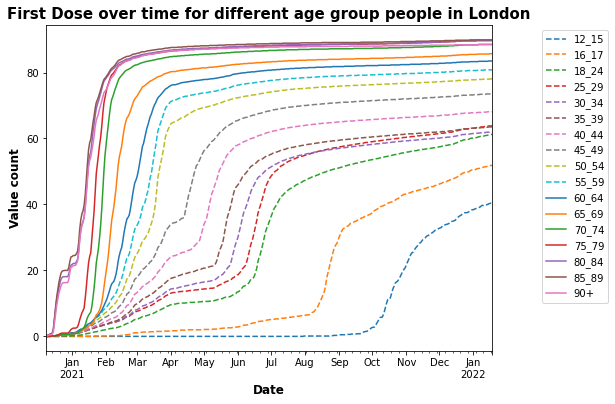

In [60]:
# 1. Aggregrate the data as an intermediate dataframe
# Moulding London Dataframe as asked in the problem statement
cum_london = covid_data_vaccinations_wide[covid_data_vaccinations_wide['area'] == 'London']
temp = cum_london[['date', 'cumVaccinationFirstDoseUptakeByVaccinationDatePercentage', 'age']]

data = []
for key, grp in temp.groupby('date'):
    data.append(grp['cumVaccinationFirstDoseUptakeByVaccinationDatePercentage'].values.T)
    
data = np.array(data)

indexes = list(set(cum_london['date']))
indexes.sort()
columns = list(set(cum_london['age']))
columns.sort()

intermediate_df = pd.DataFrame(data, index = indexes, columns = columns)

# 2. Plot to visualize the transform data
intermediate_df.plot(style=['--' for _ in range(10)], figsize=(8, 6))

plt.legend(bbox_to_anchor=(1.1, 1.0))
# plt.subplots(figsize=(8, 6))

plt.xlabel('Date', fontweight ='bold', fontsize = 12)
plt.ylabel('Value count', fontweight ='bold', fontsize = 12)
plt.title("First Dose over time for different age group people in London", fontweight ='bold', fontsize = 15)
plt.show()

# 3. Answer the question posed with comment
# Older people were vaccinated before younger people as the graph of First Dose over time demonstrates, this strategy 
# was employed due to the vulnerability of certain group ages more than others. 

### Task 28

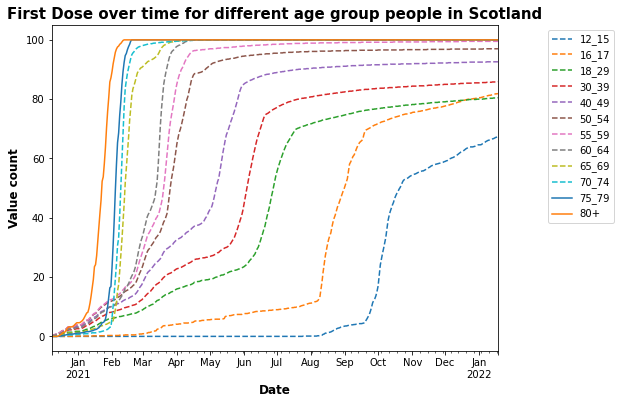

In [62]:
# 1. Aggregrate the data as an intermediate dataframe
# Moulding Scotland Dataframe as asked in the problem statement
cum_scotland = covid_data_vaccinations_wide[covid_data_vaccinations_wide['area'] == 'Scotland']

temp =cum_scotland[['date', 'cumVaccinationFirstDoseUptakeByVaccinationDatePercentage', 'age']]

l = []
#looping in the dataframe
for key, grp in temp.groupby('date'):
    l.append(grp['cumVaccinationFirstDoseUptakeByVaccinationDatePercentage'].values.T)
    
l = np.array(l)

indexes = list(set(cum_scotland['date']))
indexes.sort()
columns = list(set(cum_scotland['age']))
columns.sort()


intermediate_df = pd.DataFrame(l, index = indexes, columns = columns)

# 2. Plot to visualize the transform data
intermediate_df.plot(style=['--' for _ in range(10)], figsize=(8, 6))
    
plt.legend(bbox_to_anchor=(1.1, 1.0))
plt.xlabel('Date', fontweight ='bold', fontsize = 12)
plt.ylabel('Value count', fontweight ='bold', fontsize = 12)
plt.title("First Dose over time for different age group people in Scotland", fontweight ='bold', fontsize = 15)
plt.show()


# 3. Answer the question posed with comment
# Age group 65-79 were vaccinated first, and vaccination of 50-64 was started when majority 
# of 65-79 age group people were vaccinated. The strategy adopted to London is very similar, as also the trend 
# of the visualisation can show. The ranges of age being vaccinated progressed once most of the older ranges 
# were vaccinated before moving onto the next relevant group of age.